# Predicting Future Sales
## Data Exploration and Cleaning Note Book

**Table of contents**
<br>Notebook Setup
1. Exploration and Cleaning<br>
    1.1 Check Characteristic values<br>
    1.2 Check Key Figure values<br>
2. Exploratory Analysis<br>
    2.1 Sales General Trend - Heat Map<br>
    2.2 Items<br>
    2.3 Shop<br>
    2.4 Category<br>

## Notebook setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import numpy as np
import calmap
import math
import calmap

### Data Manipulation Options

You may change the value below to remove or keep the data as is <br>
REMOVE_NEGATIVE_COUNTS: Remove Negative item_cnt_day <br>
REMOVE_NONREV_PRODUCT: Remove product that is not relevant to prediction <br>
REMOVE_NON_PREDICT_ITM: Remove the item(s) that is not required for prediction <br>

Please note that changing these parameter will impact the some of the 
result below because some data set is removed after changing the value

In [2]:
REMOVE_NEGATIVE_COUNTS = True
REMOVE_NEGATIVE_PRICE = True
REMOVE_NON_PREDICT_ITM = True

## 1. Exploration and Cleaning

In [3]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
categories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

In [4]:
#check sales
sales.date.describe()
sales.sort_values(by='date')
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### 1.1 Check Characteristic values

**1.1.1 Sales**

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Check for null value

In [7]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<br>
From first 5 rows, we can already infer that there is data quality issue:

There is a negative value showing in the itm_cnt_day field. 

Let's remove the negative value if required (can be configure at the Data 
Manipulation Options section above)
<br>

In [8]:
if REMOVE_NEGATIVE_COUNTS:
    sales = sales[sales.item_cnt_day >= 0]
if REMOVE_NEGATIVE_PRICE:
    sales = sales[sales.item_price >= 0]
if REMOVE_NON_PREDICT_ITM: 
    testUniID = list(test.item_id.unique())

    for idx in items.index:
        id = items.loc[idx, "item_id"]
        items.loc[idx, "Required"] = id in testUniID
# pre merge to removed data that are not related for prediction
# will drop the "Required" column for cleaner data. 
    sales = sales.merge(items, how="left", on="item_id")
    
    sales = sales[sales.Required == True]
    
# Drop column for cleaner data
    sales = sales.iloc[:, 0:6]

print()    
print("Total Number of rows for sales data frame: {}".format(len(sales))) 
print()
sales.head()


Total Number of rows for sales data frame: 1442564



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
9,03.01.2013,0,25,2574,399.0,2.0
10,05.01.2013,0,25,2574,399.0,1.0
11,07.01.2013,0,25,2574,399.0,1.0
12,08.01.2013,0,25,2574,399.0,2.0


Let's check whether sales have duplicate data 

In [9]:
print("number of duplicates : {}".format(
    sales.duplicated(subset=["date", "shop_id", "item_id"]).sum()))

checksales = sales[sales.duplicated(subset=["date", "shop_id", 
                                            "item_id"], keep=False)].copy()

checksales.sort_values(by = ["item_id","shop_id"])

number of duplicates : 11


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1492994,23.03.2014,14,21,3423,999.00,1.0
1492995,23.03.2014,14,21,3423,999.00,1.0
1861693,12.07.2014,18,25,3423,999.00,1.0
1861711,12.07.2014,18,25,3423,999.00,1.0
1431756,23.02.2014,13,50,3423,999.00,1.0
1431758,23.02.2014,13,50,3423,999.00,1.0
1667711,01.05.2014,16,50,3423,999.00,1.0
1667712,01.05.2014,16,50,3423,999.00,1.0
2266491,26.12.2014,23,17,3424,999.00,2.0
2266492,26.12.2014,23,17,3424,1199.00,1.0


Let's check whether all the duplicate data is required for prediction (appear in test.csv) or not.

In [10]:
testUniID = list(test.item_id.unique())

for idx in checksales.index:
    id = checksales.loc[idx, "item_id"]
    checksales.loc[idx, "Required"] = id in testUniID

#checksales[checksales.Required == False]
checksales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Required
142262,18.02.2013,1,16,15702,149.00,1.0,True
142263,18.02.2013,1,16,15702,549.00,1.0,True
1431756,23.02.2014,13,50,3423,999.00,1.0,True
1431758,23.02.2014,13,50,3423,999.00,1.0,True
1492994,23.03.2014,14,21,3423,999.00,1.0,True
1492995,23.03.2014,14,21,3423,999.00,1.0,True
1667711,01.05.2014,16,50,3423,999.00,1.0,True
1667712,01.05.2014,16,50,3423,999.00,1.0,True
1861693,12.07.2014,18,25,3423,999.00,1.0,True
1861711,12.07.2014,18,25,3423,999.00,1.0,True


The difference betweeen the duplicate data is not far so we will keep the duplicate data.

Let's check on the date format

In [11]:
sales.date.describe()

count        1442564
unique          1034
top       30.12.2014
freq            6796
Name: date, dtype: object

Let's convert the date to correct format

In [12]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst = True)

sales.date.describe()

count                 1442564
unique                   1034
top       2014-12-30 00:00:00
freq                     6796
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

The data is now in time stamp format

**1.1.2 Items**

In [13]:
print()
print("Total Number of rows for items data frame: {}".format(len(items)))
print()
items.head()


Total Number of rows for items data frame: 22170



,item_name,item_id,item_category_id,Required
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,False
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,False
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,False
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,False
4,***КОРОБКА (СТЕКЛО) D,4,40,False


In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
 3   Required          22170 non-null  object
dtypes: int64(2), object(2)
memory usage: 692.9+ KB


Let's check on the item_name for Russian Name. The item_name duplication will also
exclude item_name that are duplicate but different category. 

In [15]:
checkitems = items[items.duplicated(
    subset=["item_name", "item_category_id"], keep=False)].copy()

checkitems

,item_name,item_id,item_category_id,Required


No duplication found for Russian item_name

**1.1.3 Categories**

In [16]:
print()
print("Total Number of rows for categories data frame: {}".format(len(categories))) 
print()
categories.head()


Total Number of rows for categories data frame: 84



,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


Let's check duplicates on the categories name

In [18]:
print("number of duplicates : {}".format(
    categories.duplicated(subset=["item_category_name"]).sum()))

number of duplicates : 0


**1.1.4 Shops**

In [19]:
print()
print("Number of rows for sales data frame : {:,.0f}".format(len(shops)))
shops.head()


Number of rows for sales data frame : 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


<br>
Let's check duplicaton for shops
<br><br>

In [21]:
print("number of duplicates : {}".format(shops.duplicated().sum()))

number of duplicates : 0


### 1.2 Check Key Figure values

**1.2.1 Normalise all data for further analysis**

In [22]:
normData = sales.merge(shops, how="left", on="shop_id")
normData = normData.merge(items, how="left", on="item_id")
normData = normData.merge(categories, how="left", on="item_category_id")
normData.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,True,Кино - Blu-Ray
1,2013-01-03,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства
2,2013-01-05,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства
3,2013-01-07,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства
4,2013-01-08,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства


In [23]:
normData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442564 entries, 0 to 1442563
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1442564 non-null  datetime64[ns]
 1   date_block_num      1442564 non-null  int64         
 2   shop_id             1442564 non-null  int64         
 3   item_id             1442564 non-null  int64         
 4   item_price          1442564 non-null  float64       
 5   item_cnt_day        1442564 non-null  float64       
 6   shop_name           1442564 non-null  object        
 7   item_name           1442564 non-null  object        
 8   item_category_id    1442564 non-null  int64         
 9   Required            1442564 non-null  object        
 10  item_category_name  1442564 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 132.1+ MB


Check for null value

In [24]:
# Check whether there is null value or not
normData.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
Required              0
item_category_name    0
dtype: int64

**1.2.2 Check Key Figure Values**

Let's have a general look on all the key figure.

In [25]:
normData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1.442564e+06,1.442564e+06,1.442564e+06,1.442564e+06,1.442564e+06,1.442564e+06
mean,1.879477e+01,3.279293e+01,9.650329e+03,1.020788e+03,1.335614e+00,4.074066e+01
std,9.083670e+00,1.616813e+01,6.305674e+03,1.805546e+03,3.191628e+00,1.863186e+01
min,0.000000e+00,0.000000e+00,3.000000e+01,5.000000e-01,1.000000e+00,2.000000e+00
25%,1.200000e+01,2.200000e+01,4.181000e+03,2.990000e+02,1.000000e+00,2.800000e+01
50%,2.000000e+01,3.100000e+01,7.856000e+03,5.490000e+02,1.000000e+00,4.000000e+01
75%,2.600000e+01,4.700000e+01,1.525700e+04,1.199000e+03,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216700e+04,5.920000e+04,2.169000e+03,8.300000e+01


**1.2.3 Check item_price**

****Note: This section will be impacted/will not able to show intended result by setting the remove parameter.**<br>
**Set all remove parameter to False to correct data**

In [26]:
normData.item_price.describe()

count    1.442564e+06
mean     1.020788e+03
std      1.805546e+03
min      5.000000e-01
25%      2.990000e+02
50%      5.490000e+02
75%      1.199000e+03
max      5.920000e+04
Name: item_price, dtype: float64

Let's put the item_pricing into a box plot

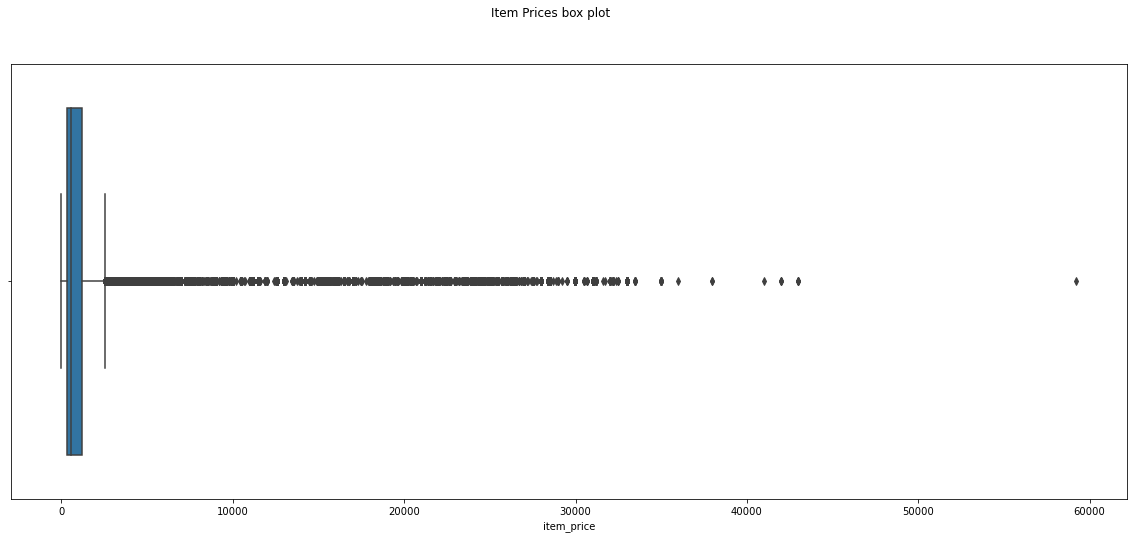

In [27]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices box plot")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

It seems that there is a extreme outlier and let's look further into the extreme outlier.

The sales_price is higher than 300000. 

In [28]:
normData[normData.item_price >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name


Note: the result above will be empty if the remove parameter is set. 

It appears that there is only 1 item for item_price >= 300000. Let's check how many 6066 item_id in the data set. 

In [29]:
print("Number of record with item_id 6066: {}".format(len(normData[normData.item_id == 6066])))

Number of record with item_id 6066: 0


Only 1 record therefore we can definately delete the outlier. 

In [30]:
normData = normData[normData.item_price < 300000]

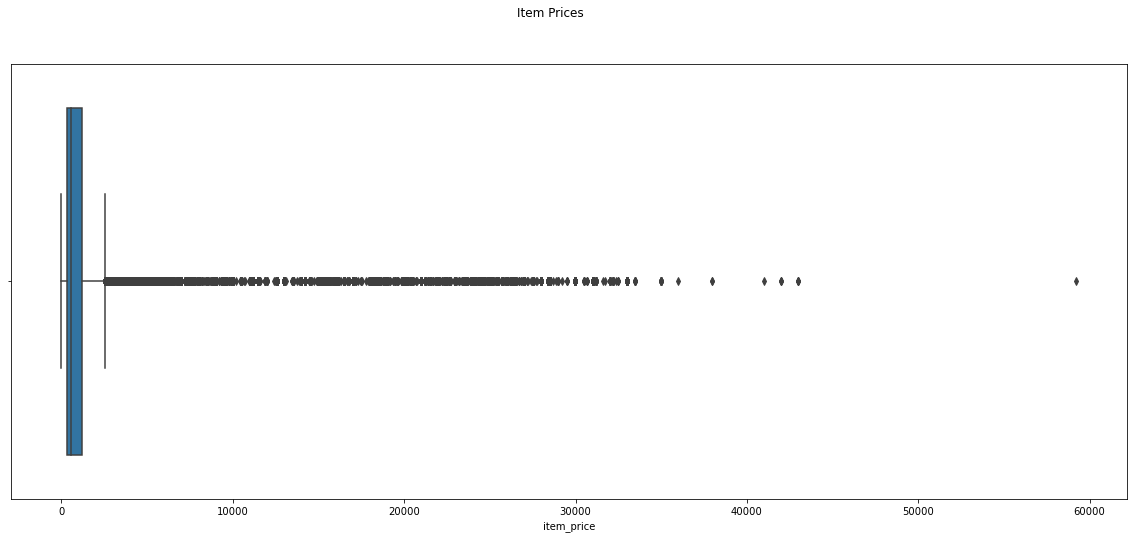

In [31]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

**1.2.4 Check item count**

In [32]:
normData.item_cnt_day.describe()

count    1.442564e+06
mean     1.335614e+00
std      3.191628e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

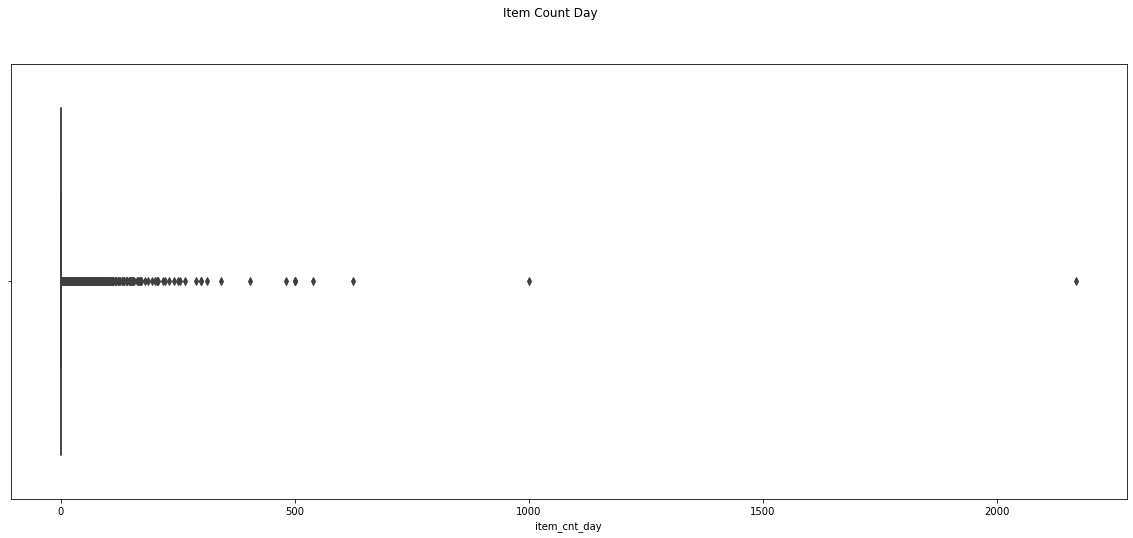

In [33]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Count Day")
sns.boxplot(x=normData.item_cnt_day, ax=ax)
plt.show()

Let's check the outlier 

In [34]:
checkItemCnt = normData[normData.item_cnt_day >= 500]

checkItemCnt

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name
556428,2014-06-28,17,25,20949,5.000000,501.0,"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
892548,2014-12-19,23,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
942094,2015-01-15,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
1152716,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1167937,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,True,Доставка товара
1417590,2015-10-14,33,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
1417977,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,True,Доставка товара


In [35]:
for idx in checkItemCnt.index:
    id = checkItemCnt.loc[idx, "item_id"]
    checkItemCnt.loc[idx, "Required"] = id in testUniID

checkItemCnt.sort_values(by= "item_id")
    
#checkItemCnt[checkItemCnt.Required == True]

C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name
1152716,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1167937,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,True,Доставка товара
1417977,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,True,Доставка товара
556428,2014-06-28,17,25,20949,5.000000,501.0,"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
892548,2014-12-19,23,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
942094,2015-01-15,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"
1417590,2015-10-14,33,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,True,"Подарки - Сумки, Альбомы, Коврики д/мыши"


It appears that some of the item_id do have high item_cnt_day number. 

Let's look further into 3731 and 8057 as they only have 1 rows

In [36]:
checkItemCnt = normData[normData.item_id == 3731]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name
1109549,2015-04-30,27,29,3731,1999.000000,1.0,"Москва ТЦ ""Новый век"" (Новокосино)","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1288345,2015-07-19,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1288344,2015-07-15,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1288343,2015-07-04,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1288342,2015-07-02,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
...,...,...,...,...,...,...,...,...,...,...,...
1150270,2015-04-14,27,18,3731,1930.034483,145.0,"Красноярск ТЦ ""Июнь""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1111192,2015-04-14,27,31,3731,1946.953216,171.0,"Москва ТЦ ""Семеновский""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1120332,2015-04-14,27,25,3731,1941.995169,207.0,"Москва ТРК ""Атриум""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания
1143881,2015-04-14,27,42,3731,1918.732441,299.0,"СПб ТК ""Невский Центр""","Grand Theft Auto V [PC, русские субтитры]",30,True,Игры PC - Стандартные издания


In [37]:
checkItemCnt = normData[normData.item_id == 8057]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name


Based on the section above, it item_cnd_day for 3731 and 8057 seem normal. Their item counts is normal comparing the same item id. 


In [38]:
print("Number of Distinct Item: " + str(len(pd.unique(normData['item_id']))))
print("Number of Distinct Item Catgory: " + str(len(pd.unique(normData['item_category_id']))))
print("Number of Distinct Shop ID: " + str(len(pd.unique(normData['shop_id']))))

Number of Distinct Item: 4737
Number of Distinct Item Catgory: 60
Number of Distinct Shop ID: 60


## 2. Exploratory Data Analysis

First we will need to add date related new columns for better analysis 

In [39]:
normData['date_month'] = normData['date'].dt.month
normData['date_year'] = normData['date'].dt.year
#Calculate total normData
normData['total_sales'] =  normData['item_price'] * normData['item_cnt_day']

Prepare the sales year split by year for reusability

**Run code below to get the cleaned data as CSV**

In [40]:
#Save data as CSV file

normData.to_csv('predictFutureSalesClean.csv') 

In [41]:
sales2013 = normData[normData['date_year'] == 2013]
sales2014 = normData[normData['date_year'] == 2014]
sales2015 = normData[normData['date_year'] == 2015]

### 2.1 General Sales Trend

In [42]:
# Find aggregate sales by day
salesMonYea2013 = sales2013.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2014 = sales2014.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2015 = sales2015.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()

totalSales = pd.concat([salesMonYea2013,salesMonYea2014,salesMonYea2015])

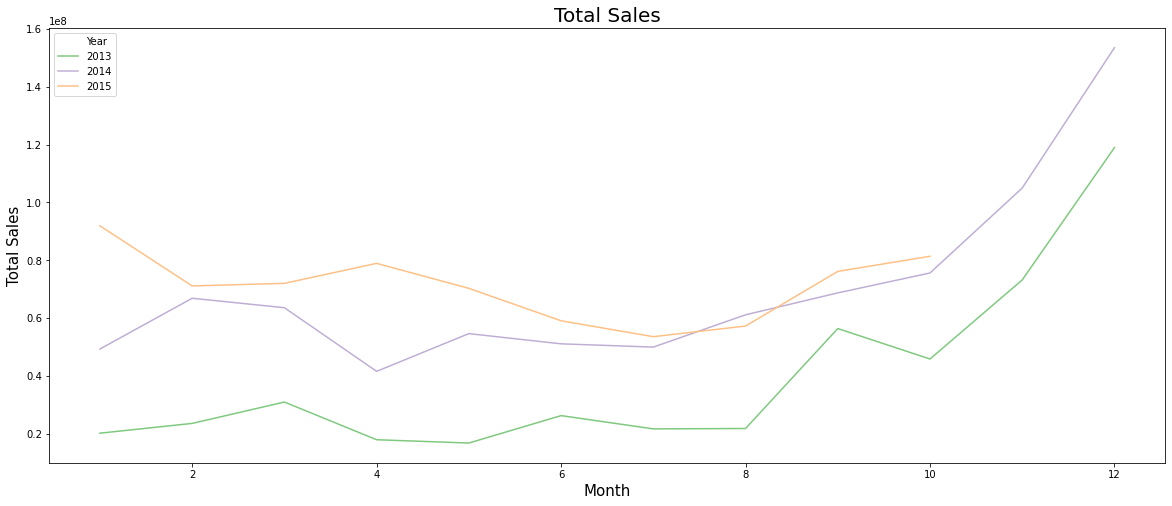

In [43]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'total_sales', data = totalSales,
           hue='date_year', palette = 'Accent')

plt.title("Total Sales", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

Let's look at the heatmap for sales trend

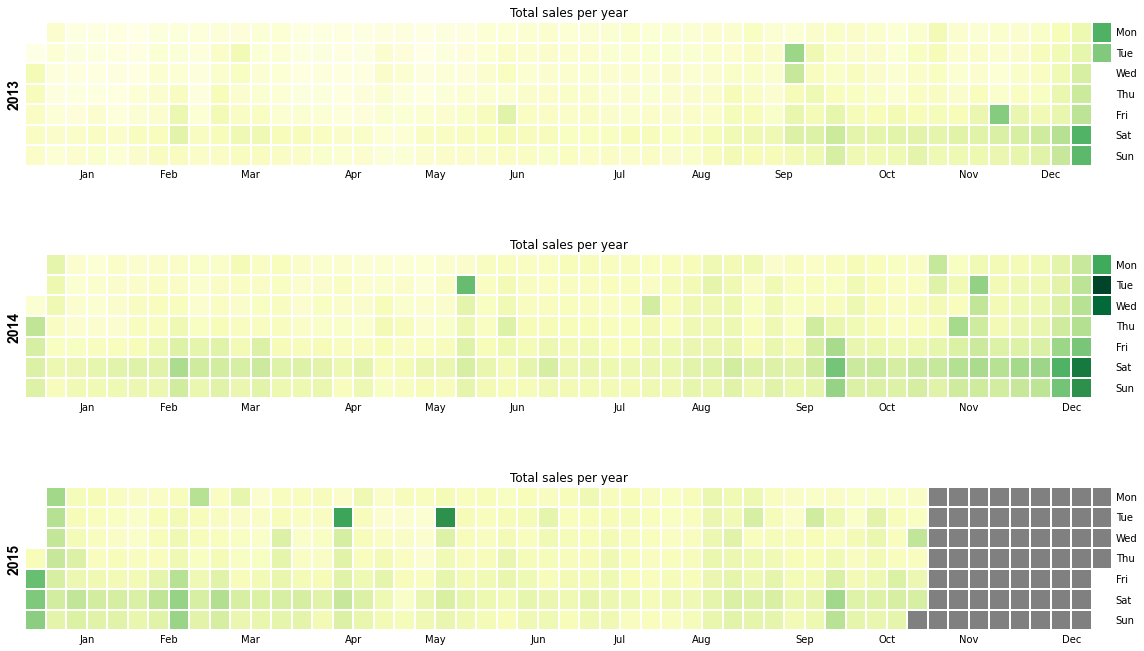

In [44]:
calHeatMap = normData[["date", "item_cnt_day"]]

calHeatMap.set_index("date", inplace = True)

calHeatMap = calHeatMap.resample("D")["item_cnt_day"].sum()

calmap.calendarplot(calHeatMap, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    cmap='YlGn',
                    fillcolor='grey',
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

### Guan - EDA

In [45]:
all_data = normData
all_data['date'] = pd.to_datetime(all_data.date, format='%Y.%m.%d')
all_data['date_week'] = all_data.date.dt.week
all_data['dayofweek_name'] = all_data.date.dt.day_name()
all_data['dayofweek_no'] = all_data.date.dt.dayofweek 
all_data['wrk_week'] = np.where(all_data['date_year']==2013, all_data['date_week'], np.where(all_data['date_year']==2014, all_data['date_week']+52, all_data['date_week']+104))

In [46]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [47]:
#sort the values on date, shop_id and item_id
all_data = all_data.sort_values(by=['date', 'shop_id', 'item_id'])

Text(0, 0.5, 'Total Sales')

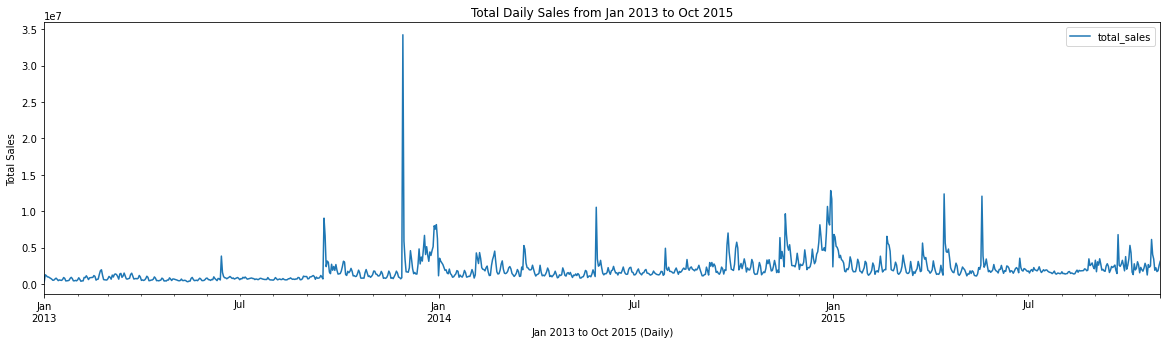

In [48]:
#plot daily line graph from jan 2013 to oct 2015
all_data_by_date = all_data[['date', 'total_sales']]

aggregations = {'total_sales':'sum'}
all_data_by_date = all_data_by_date.groupby(['date'], as_index=False).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)

ax = all_data_by_date.plot(x='date', y='total_sales', kind='line', figsize=(20,5))
ax.set_title('Total Daily Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Daily)")
ax.set_ylabel("Total Sales")

Text(0, 0.5, 'Total Sales')

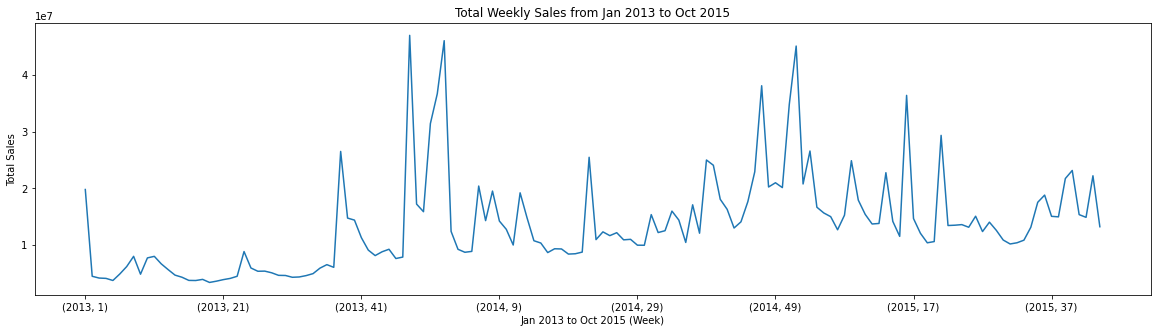

In [49]:
#plot weekly line graph from jan 2013 to oct 2015
all_data_by_week = all_data[['date', 'total_sales', 'date_week', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_week = all_data_by_week.groupby(['date_year', 'date_week']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_week['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Weekly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Week)")
ax.set_ylabel("Total Sales")

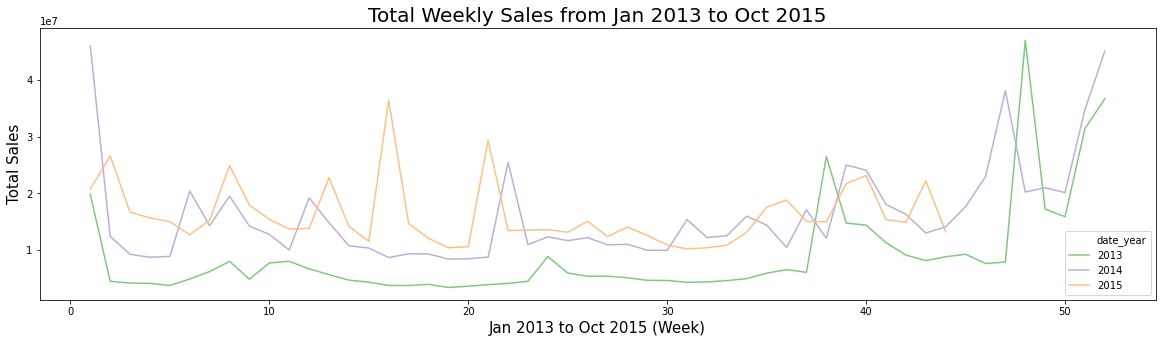

In [50]:
#plot weekly graph by year for better comparison
all_data_by_week = all_data.groupby(['date_week', 'date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg


plt.rcParams['figure.figsize']=(20, 5)
sns.lineplot(x='date_week', y='total_sales', hue='date_year', data = all_data_by_week, palette='Accent')
plt.title("Total Weekly Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Week)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
#plt.figure(figsize=(100, 6))
plt.show()

Text(0, 0.5, 'Total Sales')

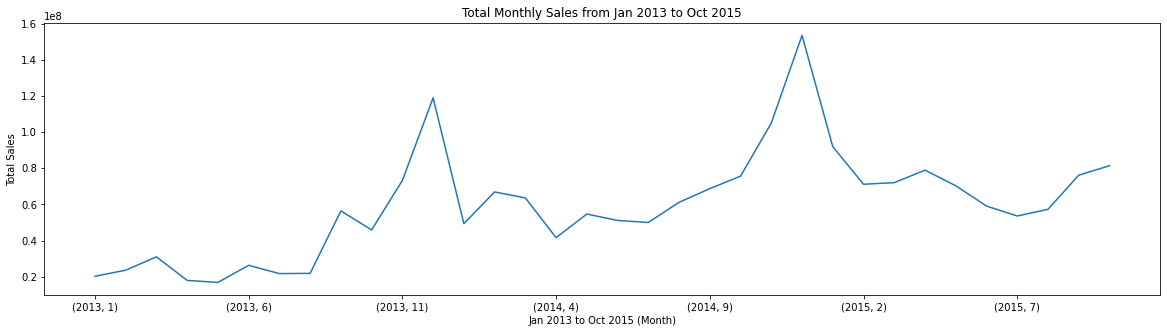

In [51]:
#plot monthly line graph from jan 2013 to oct 2015
all_data_by_month = all_data[['date', 'total_sales', 'date_month', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_month = all_data_by_month.groupby(['date_year', 'date_month']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_month['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Monthly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Month)")
ax.set_ylabel("Total Sales")

Let's check item count trend as well

In [52]:
# Find aggregate sales by day
itemCntYea2013 = sales2013.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2014 = sales2014.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2015 = sales2015.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()

itemCntYea = pd.concat([itemCntYea2013,itemCntYea2014,itemCntYea2015])

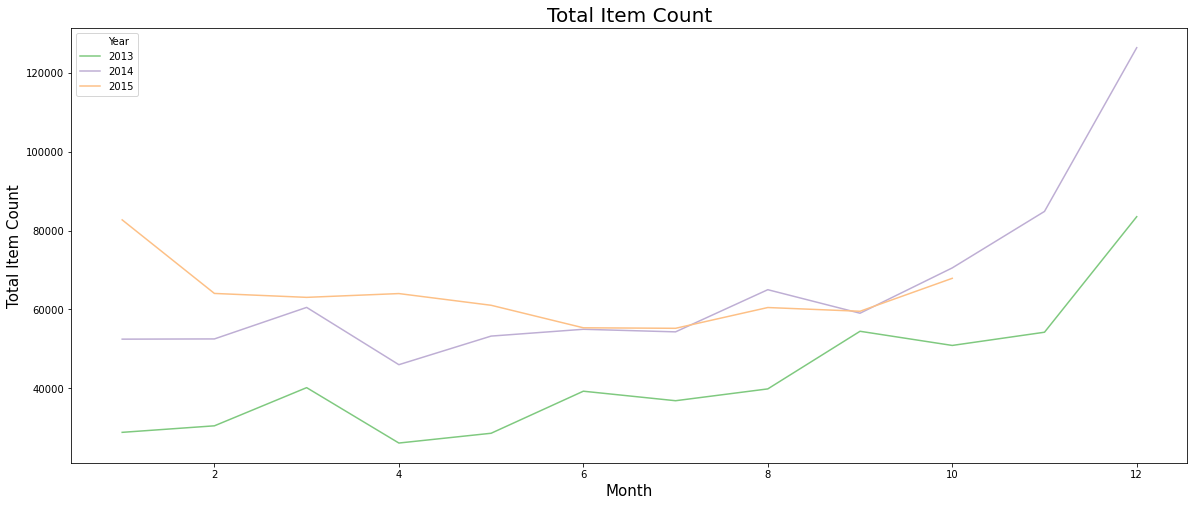

In [53]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'item_cnt_day', data = itemCntYea,
           hue='date_year', palette = 'Accent')

plt.title("Total Item Count", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Item Count", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

### 2.2 Items

In [54]:

item_sales = normData.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()

item_sales

,item_id,total_sales
0,30,"722,217.65"
1,31,"864,296.24"
2,32,"532,038.52"
3,33,"213,040.50"
4,38,"158,783.85"
...,...,...
4732,22162,"269,111.52"
4733,22163,"12,368.49"
4734,22164,"354,395.03"
4735,22166,"52,200.00"


Let's explore the graph for Top 10 Total Sales by Item

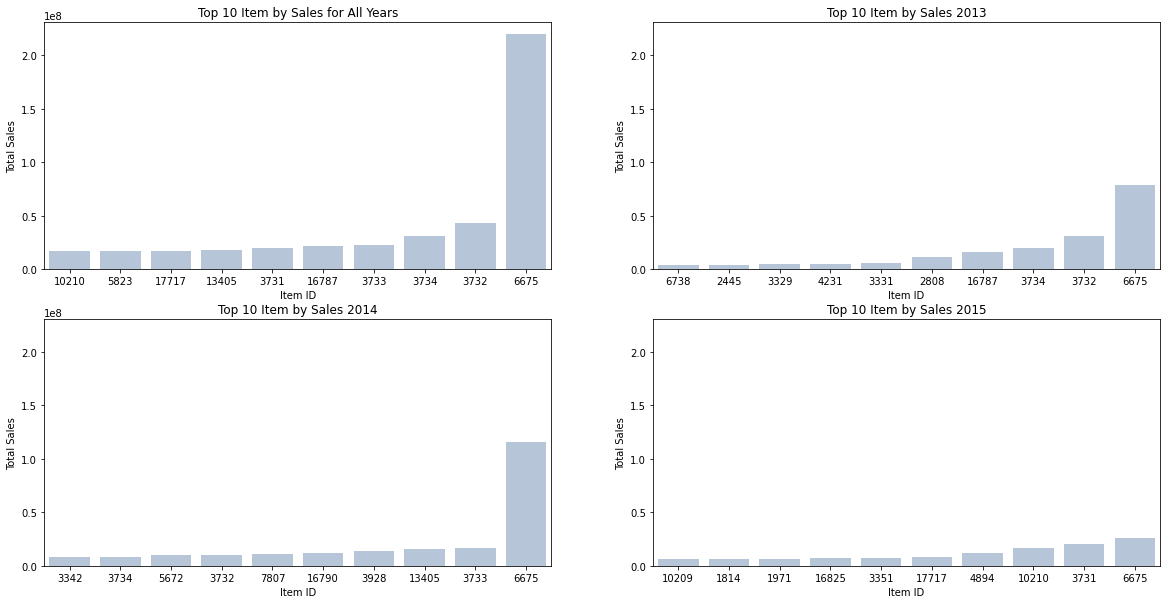

In [55]:
def buildItemSalesGraph(df,ax0,year):
    
    item_sales = df.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()
    
    item_sales = item_sales.sort_values(by=['total_sales'], ascending =False)

    item_sales = item_sales.head(n = 10)
    
    axTotal= sns.barplot(ax=ax0, x = item_sales.item_id, 
                y = item_sales.total_sales,
               order= item_sales.sort_values('total_sales').item_id,
                color = 'lightsteelblue')
   
    if year == '':
        axTotal.title.set_text('Top 10 Item by Sales for All Years')
    else: 
        title = 'Top 10 Item by Sales ' + str(year)
        axTotal.title.set_text(title)
    
    axTotal.set_xlabel('Item ID')
    axTotal.set_ylabel('Total Sales')
    axTotal.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemSalesGraph(normData,axes[0,0],'')
buildItemSalesGraph(sales2013,axes[0,1],2013)
buildItemSalesGraph(sales2014,axes[1,0],2014)
buildItemSalesGraph(sales2015,axes[1,1],2015)

Let's explore the graph for Top 10 Total Sales by Item

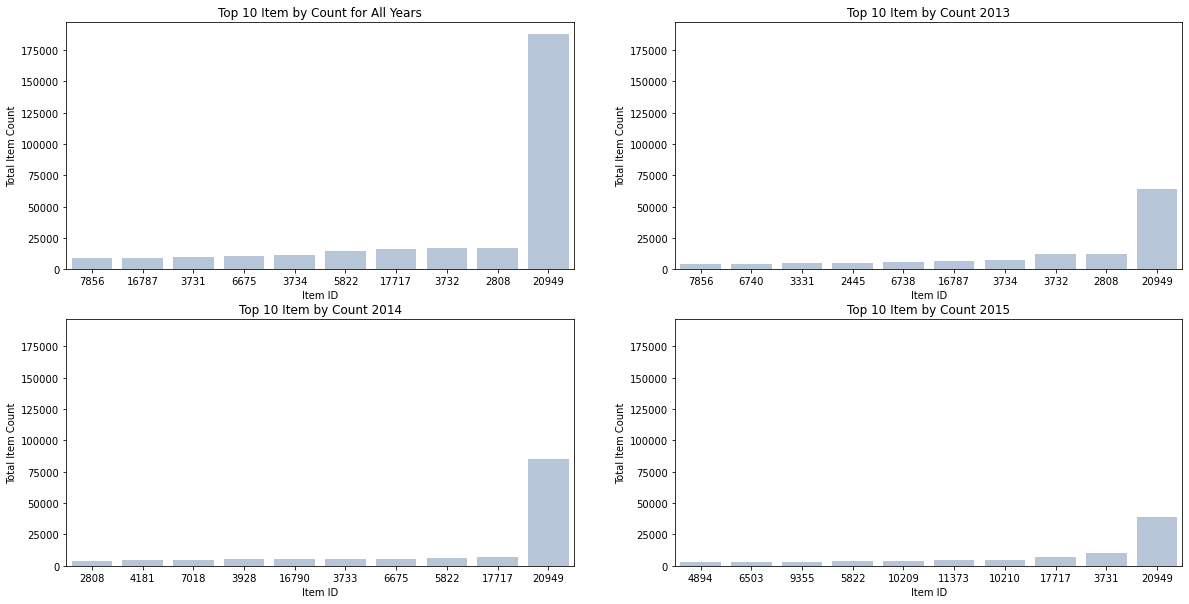

In [56]:
def buildItemCntGraph(df,ax0,year):

    sales_item_cnt = df.groupby(['item_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_item_cnt = sales_item_cnt.sort_values(by=['item_cnt_day'], ascending =False)

    sales_item_cnt = sales_item_cnt.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_item_cnt.item_id, 
                y = sales_item_cnt.item_cnt_day,
               order=sales_item_cnt.sort_values('item_cnt_day').item_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Item by Count for All Years')
    else: 
        title = 'Top 10 Item by Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item ID')
    ax.set_ylabel('Total Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemCntGraph(normData,axes[0,0],'')
buildItemCntGraph(sales2013,axes[0,1],2013)
buildItemCntGraph(sales2014,axes[1,0],2014)
buildItemCntGraph(sales2015,axes[1,1],2015)

### 2.3 Shop 

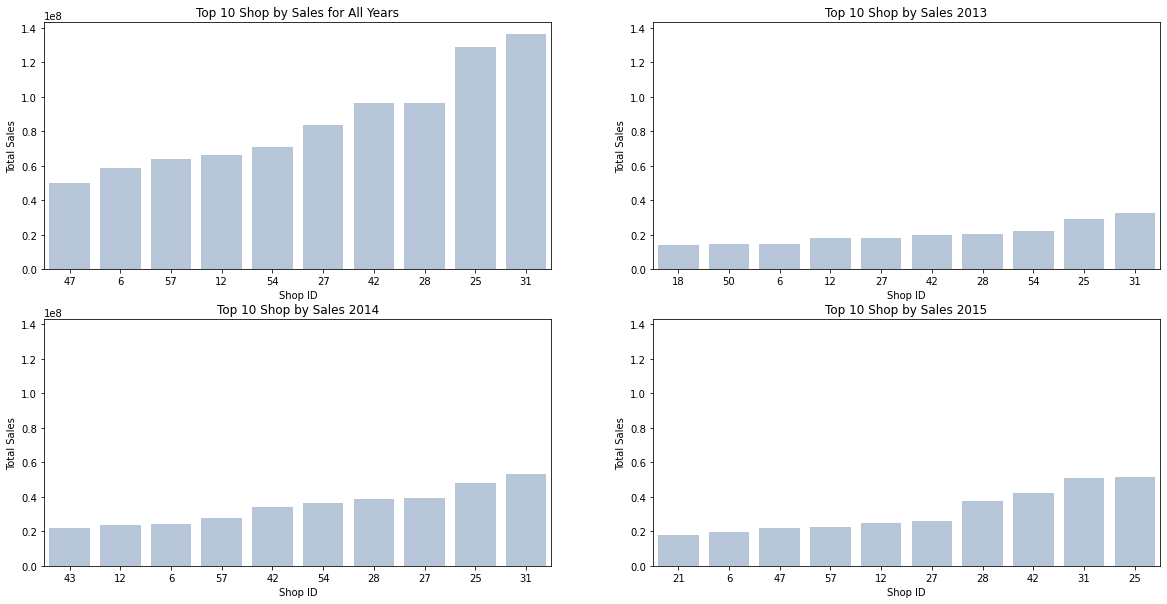

In [57]:
# Checking Shop with top 10 Sales
# Prepare subplots
def buildShopSalesGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['total_sales']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['total_sales'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.total_sales,
               order=sales_shop.sort_values('total_sales').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Sales for All Years')
    else: 
        title = 'Top 10 Shop by Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildShopSalesGraph(normData,axes[0,0],'')
buildShopSalesGraph(sales2013,axes[0,1],2013)
buildShopSalesGraph(sales2014,axes[1,0],2014)
buildShopSalesGraph(sales2015,axes[1,1],2015)

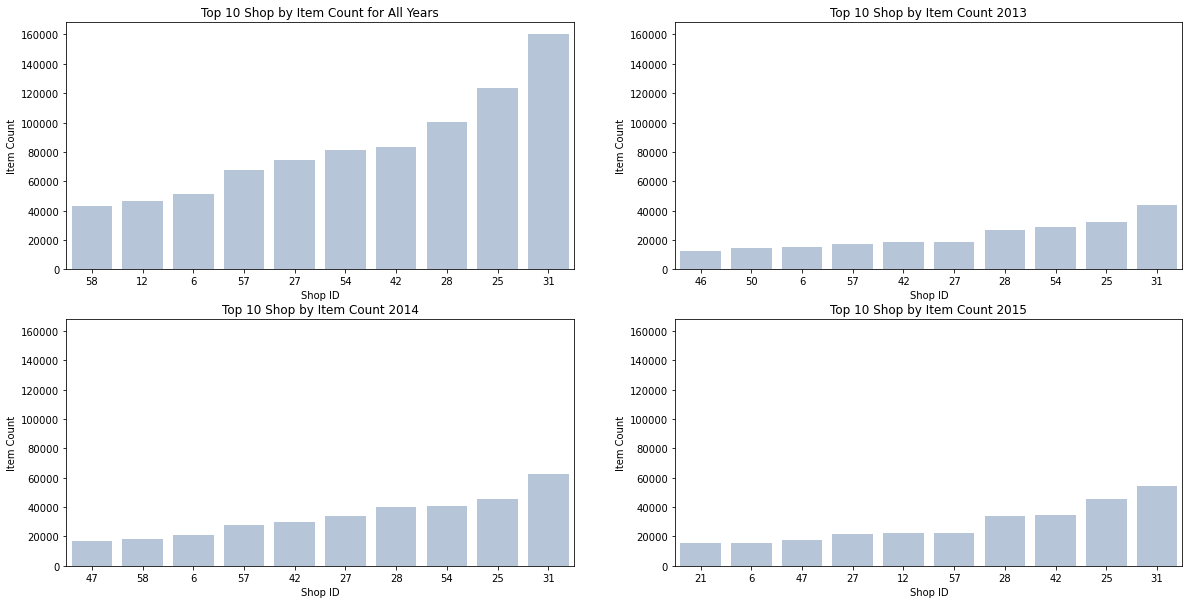

In [58]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildShopCntGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['item_cnt_day'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.item_cnt_day,
               order=sales_shop.sort_values('item_cnt_day').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildShopCntGraph(normData,axes[0,0],'')
buildShopCntGraph(sales2013,axes[0,1],2013)
buildShopCntGraph(sales2014,axes[1,0],2014)
buildShopCntGraph(sales2015,axes[1,1],2015)



### 2.4 Categories

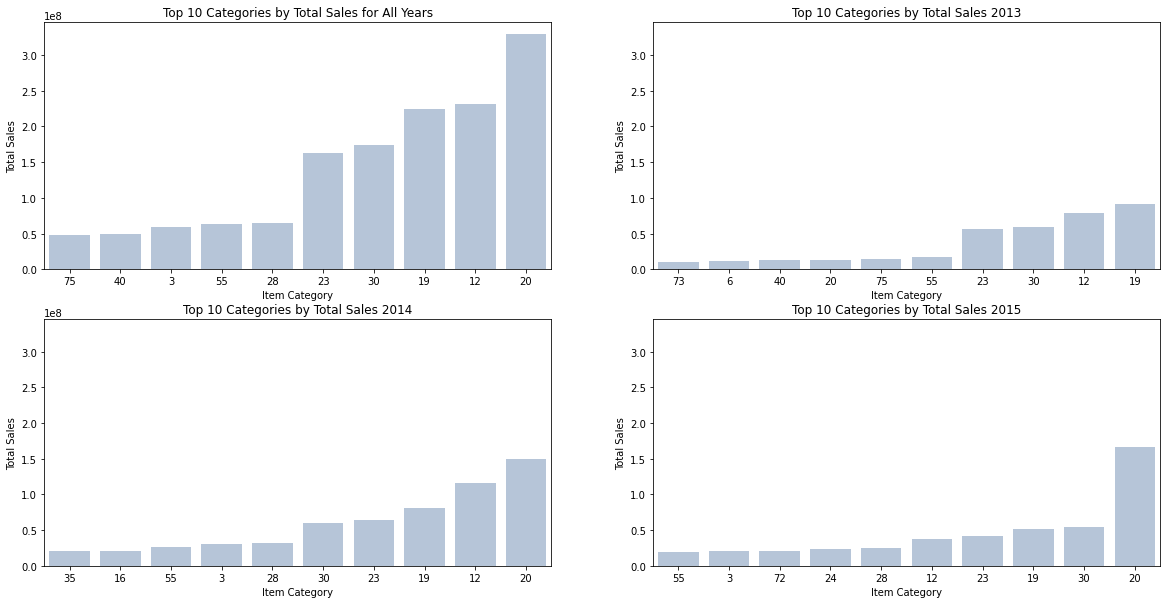

In [59]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatSalesGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['total_sales']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['total_sales'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.total_sales,
               order=sales_cat.sort_values('total_sales').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Categories by Total Sales for All Years')
    else: 
        title = 'Top 10 Categories by Total Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatSalesGraph(normData,axes[0,0],'')
buildCatSalesGraph(sales2013,axes[0,1],2013)
buildCatSalesGraph(sales2014,axes[1,0],2014)
buildCatSalesGraph(sales2015,axes[1,1],2015)

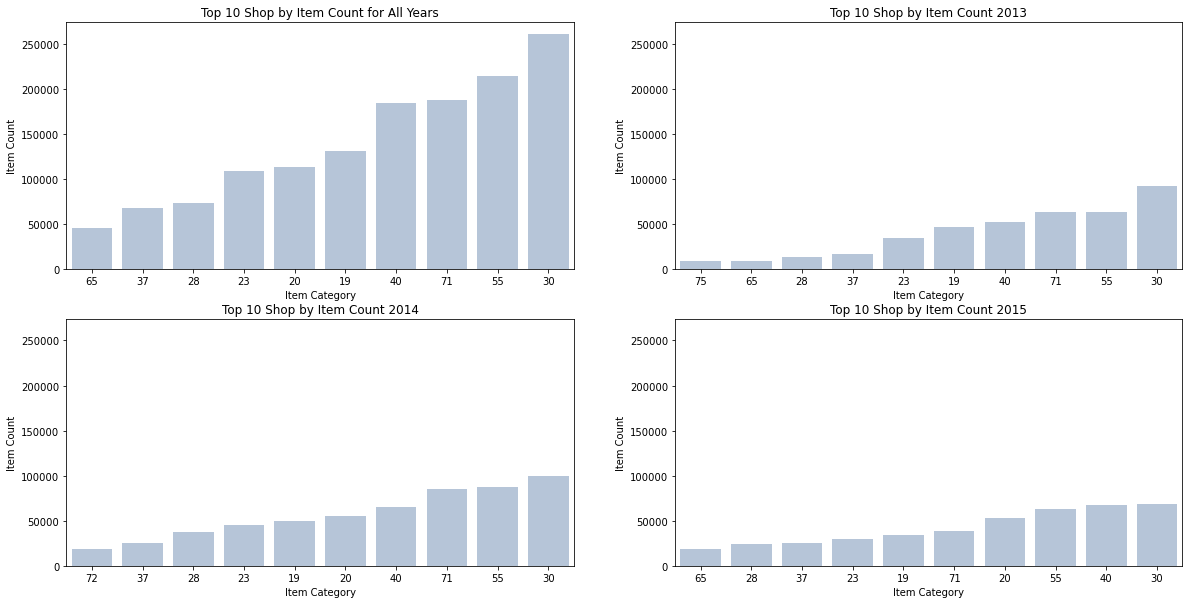

In [60]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatCntGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['item_cnt_day'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.item_cnt_day,
               order=sales_cat.sort_values('item_cnt_day').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatCntGraph(normData,axes[0,0],'')
buildCatCntGraph(sales2013,axes[0,1],2013)
buildCatCntGraph(sales2014,axes[1,0],2014)
buildCatCntGraph(sales2015,axes[1,1],2015)

